# Interface Reactions

This notebook shows how to
* Obtain information about interface reactions between two solid substances in contact, and
* Plot reaction energy as a function of mixing ratio.

Written using:
- pymatgen==2018.3.13

We use the [Materials Project API](https://github.com/materialsproject/mapidoc) to obtain energies of compounds.

In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.interface_reactions import InterfacialReactivity
from pymatgen.analysis.phase_diagram import PhaseDiagram, GrandPotentialPhaseDiagram
from pymatgen import Composition, Element

%matplotlib inline

# Initialize the REST API interface. You may need to put your own API key in as an arg.
mpr = MPRester()

First, set the values of the two reactants. Optionally, simulate the case where the reaction system is in contact with an elemental reservoir.

Because the methodology here is to generate a pseudo-binary phase stability diagram of two reactants as a function of mixing ratio, the addition of an elemental reservoir implies construction of a so-called _grand potential phase diagram_.

In [2]:
# Chemical formulae for two solid reactants.
reactant1 = 'LiCoO2'
reactant2 = 'Li3PS4'

# Is the system open to an elemental reservoir?
grand = True

if grand:
    # Element in the elemental reservoir.
    open_el = 'Co'
    # Relative chemical potential vs. pure substance. Must be non-positive.
    relative_mu = -1

Now, compile the critical reaction information:

In [3]:
# Get the compositions of the reactants
comp1 = Composition(reactant1)
comp2 = Composition(reactant2)

# Gather all elements involved in the chemical system.
elements = [e.symbol for e in comp1.elements + comp2.elements]
if grand:
    elements.append(open_el)
elements = list(set(elements)) # Remove duplicates

# Get all entries in the chemical system
entries = mpr.get_entries_in_chemsys(elements)

# Build a phase diagram using these entries.
pd = PhaseDiagram(entries)

# For an open system, include the grand potential phase diagram.
if grand:
    # Get the chemical potential of the pure subtance.
    mu = pd.get_transition_chempots(Element(open_el))[0]
    # Set the chemical potential in the elemental reservoir.
    chempots = {open_el: relative_mu + mu}
    # Build the grand potential phase diagram
    gpd = GrandPotentialPhaseDiagram(entries, chempots)
    # Create InterfacialReactivity object.
    interface = InterfacialReactivity(
        comp1, comp2, gpd, norm=True, include_no_mixing_energy=True, pd_non_grand=pd, use_hull_energy=False)
else:
    interface = InterfacialReactivity(
        comp1, comp2, pd, norm=True, include_no_mixing_energy=False, pd_non_grand=None, use_hull_energy=False)

From here, you can plot reaction energy versus mixing ratio:

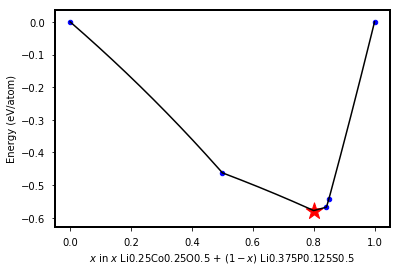

In [4]:
plt = interface.plot()

You can also collect the critical reaction equations at each point:

In [5]:
from collections import OrderedDict
from pandas import DataFrame

critical_rxns = [
    OrderedDict([
        ("mixing ratio", round(ratio, 4)),
        ("reaction energy (eV/atom)", round(energy, 4)),
        ("reaction", rxn),
    ])
    for _, ratio, energy, rxn in interface.get_kinks()]
DataFrame(critical_rxns)

,mixing ratio,reaction energy (eV/atom),reaction
0,0.0000,0.0000,Li3PS4 -> Li3PS4
1,0.5000,-0.4624,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + 1.5 CoS2 ...
2,0.8000,-0.5781,0.3333 Li3PS4 + 2.667 LiCoO2 -> 2.667 Co + Li2...
3,0.8421,-0.5676,0.75 Li3PS4 + 8 LiCoO2 -> 8 Co + Li2O + 3 Li2S...
4,0.8500,-0.5426,1.5 Li3PS4 + 17 LiCoO2 -> 16 Co + Li5CoO4 + 6 ...
5,1.0000,-0.0000,LiCoO2 -> LiCoO2


Finally, note that the reaction equations are `Reaction` objects suitable for structured analysis:

In [6]:
rxn = critical_rxns[2]["reaction"]
print(rxn)
print(type(rxn))

0.3333 Li3PS4 + 2.667 LiCoO2 -> 2.667 Co + Li2SO4 + 0.3333 Li2S + 0.3333 Li3PO4
<class 'pymatgen.analysis.reaction_calculator.Reaction'>


Now, the REST API interface provides a shortcut to obtain reaction information in a list of map.

In [7]:
# Get interface reaction information for reactants LiCoO2 and Li3PS4 in open system to Co.
kinks_from_API = mpr.get_interface_reactions('LiCoO2','Li3PS4', 
                                             open_el='Co', relative_mu=-1, use_hull_energy=False)

# Get inforamtion for the second critical reaction.
print(kinks_from_API[1])

{'energy': -0.46238682625000127, 'ratio': 0.49999999999999994, 'rxn': Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + Li3PO4 + 1.5 CoS2}


The critical reaction information from REST API should be the same as in the previous table:

In [8]:
critical_rxns_from_API = [
    OrderedDict([
        ("mixing ratio", round(reaction['ratio'], 4)),
        ("reaction energy (eV/atom)", round(reaction['energy'], 4)),
        ("reaction", reaction['rxn']),
    ])
    for reaction in kinks_from_API]
DataFrame(critical_rxns_from_API)

,mixing ratio,reaction energy (eV/atom),reaction
0,0.0000,0.0000,Li3PS4 -> Li3PS4
1,0.5000,-0.4624,Li3PS4 + 2 LiCoO2 -> 0.5 Co + Li2S + Li3PO4 + ...
2,0.8000,-0.5781,0.3333 Li3PS4 + 2.667 LiCoO2 -> 2.667 Co + Li2...
3,0.8421,-0.5676,0.75 Li3PS4 + 8 LiCoO2 -> 8 Co + Li2O + 3 Li2S...
4,0.8500,-0.5426,1.5 Li3PS4 + 17 LiCoO2 -> 16 Co + Li5CoO4 + 6 ...
5,1.0000,0.0000,LiCoO2 -> LiCoO2
